# Experiments with logistic regression model for expected goals (xG) prediction.

**Note:**
- Use this file to improve the model, try different features, regularization techniques, etc.
- This file is only for experimentation, do not log to MLflow.
- Implement important changes in the main training script src/tasks/xg/train/train_xg.py.

In [1]:

import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

print(os.getcwd())

# Add project root to Python path
root = Path(os.getcwd()).parents[3]
sys.path.insert(1, str(root))

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from src.common import io
from src.tasks.xg.features.pipeline import build_feature_pipeline
from src.tasks.xg.train.train_xg import evaluate_model



/Users/cristiandiasdecastro/Documents/dev/football-data-analysis/src/tasks/xg/notebooks


In [2]:
# Load and prepare the data

df = io.read_table(Path(root) / "data/gold/xg_features.parquet")
included_features = [
    "shot_distance",
    "shot_angle",
    "body_part_right_foot",
    "body_part_left_foot",
    "body_part_head",
    "body_part_other",
    "is_open_play",
    "one_on_one",
]

pipeline = build_feature_pipeline()
X = pipeline.transform(df)[included_features].dropna()
y = df["is_goal"].dropna()

In [3]:
# Feature engineering. This step happens inside `prepare_features` on the main workflow.

X["log_angle"] = np.log(X["shot_angle"] + 1e-5) # penalty for small (tight) angles
X["one_on_one_x_log_angle"] = X["one_on_one"].astype(int) * X["log_angle"] # in one on one, angle is less important
X["one_on_one_x_dist"] = X["one_on_one"].astype(int) * X["shot_distance"] # in one on one, distance is less important

print(X.columns)

Index(['shot_distance', 'shot_angle', 'body_part_right_foot',
       'body_part_left_foot', 'body_part_head', 'body_part_other',
       'is_open_play', 'one_on_one', 'log_angle', 'one_on_one_x_log_angle',
       'one_on_one_x_dist'],
      dtype='object')


In [4]:
# Model training

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = XGBClassifier(random_state=42, eval_metric='logloss')
    model.fit(X_train, y_train)
     
    return model, X_train, X_test, y_train, y_test

model, X_train, X_test, y_train, y_test = train_model(X, y)

Test Performance: log_loss=0.306, brier_score=0.082
Train Performance:
  ROC-AUC: 0.937
  Accuracy: 0.921
  Precision: 0.829
  Recall: 0.279
  F1 Score: 0.417
  Log Loss: 0.189
  Brier Score: 0.056

Test Performance:
  ROC-AUC: 0.709
  Accuracy: 0.902
  Precision: 0.366
  Recall: 0.106
  F1 Score: 0.165
  Log Loss: 0.306
  Brier Score: 0.082



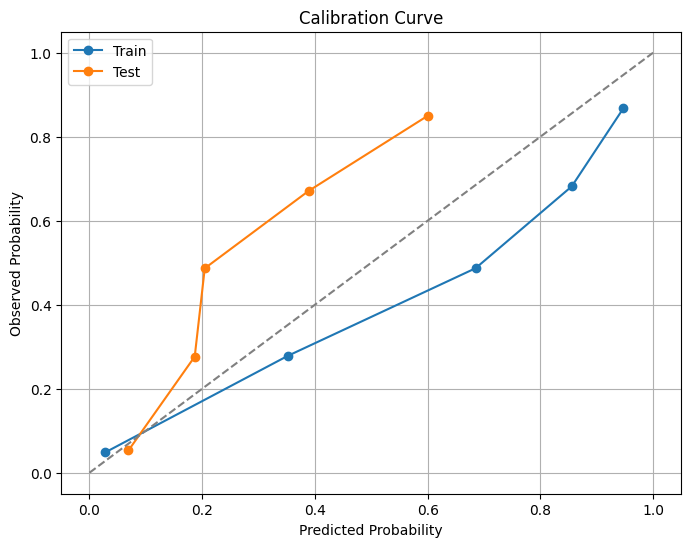

In [5]:
# Evaluate model

metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
for dataset in ["train", "test"]:
    print(f"{dataset.capitalize()} Performance:")
    print(f"  ROC-AUC: {metrics[dataset]['roc_auc']:.3f}")
    print(f"  Accuracy: {metrics[dataset]['accuracy']:.3f}")
    print(f"  Precision: {metrics[dataset]['precision']:.3f}")
    print(f"  Recall: {metrics[dataset]['recall']:.3f}")
    print(f"  F1 Score: {metrics[dataset]['f1']:.3f}")
    print(f"  Log Loss: {metrics[dataset]['log_loss']:.3f}")
    print(f"  Brier Score: {metrics[dataset]['brier_score']:.3f}")
    print()

# Calibration curve
calib_curve_train = metrics["train"]["calibration_curve"]
calib_curve_test = metrics["test"]["calibration_curve"]

plt.figure(figsize=(8, 6))
plt.plot(calib_curve_train[0], calib_curve_train[1], marker='o', label='Train')
plt.plot(calib_curve_test[0], calib_curve_test[1], marker='o', label='Test')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()